In [1]:
!pip install transformers==4.15.0
!pip install datasets==1.16.0
!pip install tensorflow

     |████████████████████████████████| 3.4 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 61.8 MB/s 
     |████████████████████████████████| 3.3 MB 56.3 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 
     |████████████████████████████████| 895 kB 43.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 298 kB 5.2 MB/s 
     |████████████████████████████████| 243 kB 60.6 MB/s 
     |████████████████████████████████| 1.1 MB 63.0 MB/s 
     |████████████████████████████████| 133 kB 69.9 MB/s 
     |████████████████████████████████| 160 kB 59.2 MB/s 
     |████████████████████████████████| 192 kB 68.0 MB/s 
     |████████████████████████████████| 271 kB 56.4 MB/s 


In [1]:
from transformers import BertForSequenceClassification, DistilBertTokenizerFast, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import load_dataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
import pandas as pd

In [2]:
'''
  Clean the data with Pandas as we did before
'''
train_df = pd.read_json('/content/classifier_data_train.json', lines=True)
train_df

,author,year,lang,text,file
0,Wilhelm Busch,unknown,de,"[Ebergötzen, nach Weihnachten 1841] Theure Elt...",busch/json/busch_1.json
1,Wilhelm Busch,unknown,de,"Es geht mir immer noch gut, und es hat mir, so...",busch/json/busch_1.json
2,Wilhelm Busch,unknown,de,Am zweiten Weihnachtstage waren wir nach dem A...,busch/json/busch_1.json
3,Wilhelm Busch,unknown,de,Ferien haben wir aber in dieser Zeit nicht geh...,busch/json/busch_1.json
4,Wilhelm Busch,unknown,de,Um Euch aber doch einen kleinen Beweis zu gebe...,busch/json/busch_1.json
...,...,...,...,...,...
39072,Virginia Woolf,1918,en,We now think of charging 1/6 anyhow; so we oug...,woolf/json/letter_999.json
39073,Virginia Woolf,1918,en,If Duncan would explain the method to Wolfe I ...,woolf/json/letter_999.json
39074,Virginia Woolf,1918,en,I should be very grateful for a line to say ho...,woolf/json/letter_999.json
39075,Virginia Woolf,1918,en,At any rate its certain to be a source of acut...,woolf/json/letter_999.json


In [3]:
# change the authors to numbers so that we can classify them
authors = train_df['author'].unique()
label_dict = {}
for index, author in enumerate(authors):
    label_dict[author] = index

train_df['author'].replace(to_replace=authors, value=list(range(len(authors))), inplace=True)
train_df = train_df.drop(train_df.columns[[1,2,4]], axis=1)
print(label_dict)

{'Wilhelm Busch': 0, 'Henrik Ibsen': 1, 'James Joyce': 2, 'Franz Kafka': 3, 'Friedrich Schiller': 4, 'Johann Wolfgang von Goethe': 5, 'Virginia Woolf': 6}


In [4]:
train_df.columns = ['label', 'text']
train_df = train_df[['text', 'label']]
train_df

,text,label
0,"[Ebergötzen, nach Weihnachten 1841] Theure Elt...",0
1,"Es geht mir immer noch gut, und es hat mir, so...",0
2,Am zweiten Weihnachtstage waren wir nach dem A...,0
3,Ferien haben wir aber in dieser Zeit nicht geh...,0
4,Um Euch aber doch einen kleinen Beweis zu gebe...,0
...,...,...
39072,We now think of charging 1/6 anyhow; so we oug...,6
39073,If Duncan would explain the method to Wolfe I ...,6
39074,I should be very grateful for a line to say ho...,6
39075,At any rate its certain to be a source of acut...,6


In [5]:
eval_df = pd.read_json('/content/classifier_data_eval.json', lines=True)
eval_df

,author,year,lang,text,file
0,Wilhelm Busch,unknown,de,"Ich war aber der Einzige, dem der Christmann s...",busch/json/busch_1.json
1,Wilhelm Busch,unknown,de,"Gestern war ich auch zum ersten Male, aber der...",busch/json/busch_10.json
2,Wilhelm Busch,unknown,de,Erst wasche Dich und schneuze Dich. Und bist D...,busch/json/busch_100.json
3,Wilhelm Busch,unknown,de,neige) ; dagegen ist die Marschall Niel hinter...,busch/json/busch_1001.json
4,Wilhelm Busch,unknown,de,Inzwischen grünt und blüht dieser heurige Früh...,busch/json/busch_1004.json
...,...,...,...,...,...
4876,Virginia Woolf,1918,en,But he is writing an account of his feeling. I...,woolf/json/letter_996.json
4877,Virginia Woolf,1918,en,"Eliot has sent us some of his poems, which we ...",woolf/json/letter_997.json
4878,Virginia Woolf,1918,en,") Eliot, I may add, said that he greatly admir...",woolf/json/letter_997.json
4879,Virginia Woolf,1918,en,Then I saw old Katie [Cromer] bobbing her head...,woolf/json/letter_999.json


In [6]:
# change the authors to numbers so that we can classify them
#Author = ['Wilhelm Busch', 'Henrik Ibsen', 'James Joyce', 'Franz Kafka', 'Friedrich Schiller', 'Johann Wolfgang von Goethe', 'Virginia Woolf']
authors = eval_df['author'].unique()
eval_df['author'].replace(to_replace=authors, value=list(range(len(authors))), inplace=True)
eval_df = eval_df.drop(eval_df.columns[[1,2,4]], axis=1)

In [7]:
eval_df.columns = ['label', 'text']
eval_df = eval_df[['text', 'label']]
eval_df

,text,label
0,"Ich war aber der Einzige, dem der Christmann s...",0
1,"Gestern war ich auch zum ersten Male, aber der...",0
2,Erst wasche Dich und schneuze Dich. Und bist D...,0
3,neige) ; dagegen ist die Marschall Niel hinter...,0
4,Inzwischen grünt und blüht dieser heurige Früh...,0
...,...,...
4876,But he is writing an account of his feeling. I...,6
4877,"Eliot has sent us some of his poems, which we ...",6
4878,") Eliot, I may add, said that he greatly admir...",6
4879,Then I saw old Katie [Cromer] bobbing her head...,6


In [8]:
train_df['label'].value_counts(normalize=True).sort_index()

0    0.128413
1    0.183535
2    0.139699
3    0.057272
4    0.054738
5    0.047087
6    0.389257
Name: label, dtype: float64

In [9]:
'''
  We use German Bert
'''
model_name = "bert-base-german-cased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizerFast'.


In [10]:
df_dataset = pd.concat([train_df,eval_df])

print(len(df_dataset))
df_dataset['label'].value_counts(normalize=True).sort_index()

43958


0    0.128418
1    0.183562
2    0.139702
3    0.057282
4    0.054711
5    0.047045
6    0.389281
Name: label, dtype: float64

In [11]:
'''
  Convert the pandas into a hugging face dataset format so it can work with the hugging face transformers.  
'''

from datasets import Dataset
dataset = Dataset.from_pandas(df_dataset)
dataset

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 43958
})

In [12]:
'''
  Split the training and testing ratio which was similar to ones before. 
'''
dataset = dataset.train_test_split(train_size= .87, test_size= .13)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 38243
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 5715
    })
})

In [13]:
tokenizer(dataset['train']['text'][:1])

{'input_ids': [[3, 963, 7189, 17593, 46, 1844, 67, 26964, 19036, 4529, 14481, 4616, 20896, 26897, 19494, 26980, 4616, 3612, 2304, 9813, 26903, 26914, 1371, 504, 1199, 7, 23349, 3109, 15099, 22336, 8471, 26917, 2117, 1119, 2118, 26904, 1657, 26901, 25468, 26898, 3713, 208, 26904, 170, 26908, 4838, 26897, 2037, 4920, 543, 26908, 59, 80, 233, 16, 70, 1818, 257, 3093, 5726, 26898, 9813, 26847, 26897, 170, 26908, 2117, 9144, 175, 14639, 26917, 24842, 138, 26914, 4]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [14]:
def tokenize_text(examples):
  return tokenizer(examples['text'], truncation=True, max_length=512)

In [15]:
'''
  Map the dataset with the tokenized text
'''

train_dataset = dataset.map(tokenize_text, batched=True)

  0%|          | 0/39 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [16]:
train_dataset=train_dataset.remove_columns('__index_level_0__')
train_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text'],
        num_rows: 38243
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text'],
        num_rows: 5715
    })
})

In [17]:
'''
  Here we create the weight for each label according to the ratio of the dataset. If the label has a high percentage of the dataset, it will have a lower weight,
  and if the label has a lower percentage of the dataset, it will have a higher weight. 
'''
class_weights = (1 - (df_dataset['label'].value_counts().sort_index()/len(df_dataset))).values
class_weights

array([0.87158196, 0.81643842, 0.86029847, 0.94271805, 0.94528868,
       0.95295509, 0.61071932])

In [18]:
torch.cuda.is_available()

True

In [19]:
'''
  Convert the weights to torch tensors. 
'''
class_weights = torch.from_numpy(class_weights).float().to("cuda")
class_weights

tensor([0.8716, 0.8164, 0.8603, 0.9427, 0.9453, 0.9530, 0.6107],
       device='cuda:0')

In [20]:
'''
  Rename the column name to labels.
''' 
train_dataset = train_dataset.rename_column('label', 'labels')

In [21]:
'''
  create a custom weight trainer.
''' 

from transformers import Trainer
import torch.nn as nn
class WeightedTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    #feed inputs to model and extract logits
    outputs = model(**inputs)
    logits = outputs.get('logits')
    #extract labels
    labels = inputs.get('labels')
    #define loss funciton with class weights
    loss_func = nn.CrossEntropyLoss(weight=class_weights)
    #comput loss
    loss = loss_func(logits, labels)
    
    return (loss, outputs) if return_outputs else loss

In [22]:
id2label ={0:'Wilhelm Busch', 1:'Henrik Ibsen', 2:'James Joyce', 3:'Franz Kafka',  4:'Friedrich Schiller', 5:'Johann Wolfgang von Goethe', 6:'Virginia Woolf'}
label2id = {'Wilhelm Busch': 0, 'Henrik Ibsen': 1, 'James Joyce': 2, 'Franz Kafka': 3, 'Friedrich Schiller': 4, 'Johann Wolfgang von Goethe': 5, 'Virginia Woolf': 6}

In [23]:
model = BertForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=len(id2label),
                                                      id2label=id2label,
                                                      label2id=label2id)

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoi

In [24]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import json
import sklearn.metrics
import sklearn.exceptions
from sklearn.utils.multiclass import unique_labels
import time
import numpy as np
import matplotlib.pyplot as plt


def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

def c_matrix(labels, preds, file_name='/content',
                                    normalize=False,
                                    cmap=plt.cm.Blues,
                                    show = True):

    np.set_printoptions(precision=2)
    if normalize:
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(labels, preds)
    # Only use the labels that appear in the data
    classes = unique_labels(labels, preds)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig(file_name)
    if(show):
       return plt.show()

    

def c_reports(labels, preds):
    return classification_report(labels, preds)

In [43]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='micro')
    acc = accuracy_score(labels, preds)
    creport = c_reports(labels, preds)
    cmatrix = c_matrix(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'c_report':creport,
        'c_matrix': cmatrix
    }

In [44]:
from transformers import TrainingArguments

batch_size =8
#log the training los at each epoch
logging_steps = len(train_dataset['train']) // batch_size
out_dir = '/content'
training_args = TrainingArguments(output_dir=out_dir,
                                  num_train_epochs=2,
                                  learning_rate=5e-05,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  logging_steps= logging_steps,
                                  fp16=True, # if you have a GPU, this makes the training go faster
                                  push_to_hub=False)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [45]:
trainer = WeightedTrainer(model=model,
                          args=training_args, 
                          compute_metrics=compute_metrics,
                          train_dataset= train_dataset['train'],
                          eval_dataset= train_dataset['test'],
                          tokenizer=tokenizer
                          )

Using amp half precision backend


The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running training *****
  Num examples = 38243
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9562


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,C Report,C Matrix
1,0.124400,0.252267,0.958180,0.958180,0.958180,0.958180,precision recall f1-score support 0 0.97 0.99 0.98 740 1 1.00 0.99 0.99 1045 2 0.95 0.96 0.95 787 3 0.96 0.95 0.95 334 4 0.79 0.84 0.82 326 5 0.80 0.74 0.77 280 6 0.98 0.98 0.98 2203 accuracy 0.96 5715 macro avg 0.92 0.92 0.92 5715 weighted avg 0.96 0.96 0.96 5715,None
2,0.063500,0.266995,0.960630,0.960630,0.960630,0.960630,precision recall f1-score support 0 0.98 0.98 0.98 740 1 1.00 0.99 0.99 1045 2 0.95 0.95 0.95 787 3 0.94 0.96 0.95 334 4 0.83 0.83 0.83 326 5 0.82 0.81 0.81 280 6 0.98 0.98 0.98 2203 accuracy 0.96 5715 macro avg 0.93 0.93 0.93 5715 weighted avg 0.96 0.96 0.96 5715,None


Saving model checkpoint to /content/checkpoint-500
Configuration saved in /content/checkpoint-500/config.json
Model weights saved in /content/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /content/checkpoint-500/tokenizer_config.json
Special tokens file saved in /content/checkpoint-500/special_tokens_map.json
Saving model checkpoint to /content/checkpoint-1000
Configuration saved in /content/checkpoint-1000/config.json
Model weights saved in /content/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in /content/checkpoint-1000/tokenizer_config.json
Special tokens file saved in /content/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to /content/checkpoint-1500
Configuration saved in /content/checkpoint-1500/config.json
Model weights saved in /content/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in /content/checkpoint-1500/tokenizer_config.json
Special tokens file saved in /content/checkpoint-1500/special_tokens_map.json
Sav

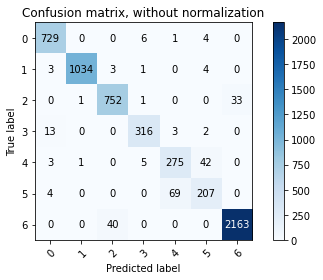

Trainer is attempting to log a value of "              precision    recall  f1-score   support

           0       0.97      0.99      0.98       740
           1       1.00      0.99      0.99      1045
           2       0.95      0.96      0.95       787
           3       0.96      0.95      0.95       334
           4       0.79      0.84      0.82       326
           5       0.80      0.74      0.77       280
           6       0.98      0.98      0.98      2203

    accuracy                           0.96      5715
   macro avg       0.92      0.92      0.92      5715
weighted avg       0.96      0.96      0.96      5715
" of type <class 'str'> for key "eval/c_report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/c_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.

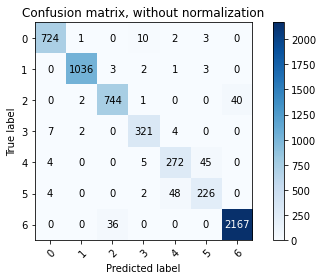

Trainer is attempting to log a value of "              precision    recall  f1-score   support

           0       0.98      0.98      0.98       740
           1       1.00      0.99      0.99      1045
           2       0.95      0.95      0.95       787
           3       0.94      0.96      0.95       334
           4       0.83      0.83      0.83       326
           5       0.82      0.81      0.81       280
           6       0.98      0.98      0.98      2203

    accuracy                           0.96      5715
   macro avg       0.93      0.93      0.93      5715
weighted avg       0.96      0.96      0.96      5715
" of type <class 'str'> for key "eval/c_report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/c_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.

TrainOutput(global_step=9562, training_loss=0.09390620115730938, metrics={'train_runtime': 1901.4752, 'train_samples_per_second': 40.225, 'train_steps_per_second': 5.029, 'total_flos': 6312256428617850.0, 'train_loss': 0.09390620115730938, 'epoch': 2.0})

In [46]:
trainer.train()

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 5715
  Batch size = 8


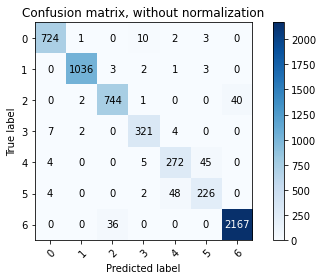

Trainer is attempting to log a value of "              precision    recall  f1-score   support

           0       0.98      0.98      0.98       740
           1       1.00      0.99      0.99      1045
           2       0.95      0.95      0.95       787
           3       0.94      0.96      0.95       334
           4       0.83      0.83      0.83       326
           5       0.82      0.81      0.81       280
           6       0.98      0.98      0.98      2203

    accuracy                           0.96      5715
   macro avg       0.93      0.93      0.93      5715
weighted avg       0.96      0.96      0.96      5715
" of type <class 'str'> for key "eval/c_report" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "None" of type <class 'NoneType'> for key "eval/c_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.

{'epoch': 2.0,
 'eval_accuracy': 0.9606299212598425,
 'eval_c_matrix': None,
 'eval_c_report': '              precision    recall  f1-score   support\n\n           0       0.98      0.98      0.98       740\n           1       1.00      0.99      0.99      1045\n           2       0.95      0.95      0.95       787\n           3       0.94      0.96      0.95       334\n           4       0.83      0.83      0.83       326\n           5       0.82      0.81      0.81       280\n           6       0.98      0.98      0.98      2203\n\n    accuracy                           0.96      5715\n   macro avg       0.93      0.93      0.93      5715\nweighted avg       0.96      0.96      0.96      5715\n',
 'eval_f1': 0.9606299212598425,
 'eval_loss': 0.26699456572532654,
 'eval_precision': 0.9606299212598425,
 'eval_recall': 0.9606299212598425,
 'eval_runtime': 39.665,
 'eval_samples_per_second': 144.082,
 'eval_steps_per_second': 18.026}

In [47]:
trainer.evaluate()